In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/My Drive/Data

/content/drive/My Drive/Data


# Import Libraries

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from transformers import BertTokenizer, BertModel
from sentence_transformers import SentenceTransformer

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Load the Dataset

In [4]:
df = pd.read_csv('mini_sentiment_dataset_1000.csv')

In [5]:
df.head()

,sentence,label
0,Terrible experience with this purchase.,0
1,Best tool I have purchased.,1
2,One star for this gadget.,0
3,Very disappointed with the gadget.,0
4,This gadget broke after one use.,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  1000 non-null   object
 1   label     1000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 15.8+ KB


In [7]:
df.label.value_counts()

,count
label,
0,511
1,489


### check for null values

In [8]:
df.isnull().sum()

,0
sentence,0
label,0


# Tokenization

In [9]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [10]:
for i in range(5):
  tokens = tokenizer.tokenize(df['sentence'][i])
  print(f"sentence {i+1}: {tokens}")

sentence 1: ['terrible', 'experience', 'with', 'this', 'purchase', '.']
sentence 2: ['best', 'tool', 'i', 'have', 'purchased', '.']
sentence 3: ['one', 'star', 'for', 'this', 'ga', '##dget', '.']
sentence 4: ['very', 'disappointed', 'with', 'the', 'ga', '##dget', '.']
sentence 5: ['this', 'ga', '##dget', 'broke', 'after', 'one', 'use', '.']


# Generate Sentence Embeddings

In [11]:
!pip install -U sentence-transformers

In [12]:
embedder = SentenceTransformer("all-MiniLM-L6-v2")

In [13]:
sentences = df['sentence'].tolist()
embeddings = embedder.encode(sentences)

In [14]:
print(embeddings.shape)

(1000, 384)


In [15]:
embeddings

array([[ 0.01918207,  0.06819552, -0.00378617, ..., -0.04727705,
        -0.00355283,  0.09277423],
       [-0.08843664,  0.01919163, -0.0309077 , ..., -0.02855196,
         0.00645209,  0.07903009],
       [-0.09173098,  0.0568145 , -0.00741941, ..., -0.01061681,
        -0.00630734,  0.05854506],
       ...,
       [-0.02773081,  0.06282116,  0.02581124, ..., -0.09316783,
        -0.08135647,  0.0505384 ],
       [-0.10148134,  0.04459385,  0.03125052, ..., -0.02174392,
        -0.03760877,  0.05777655],
       [-0.09126076,  0.01332616, -0.04424245, ..., -0.0495951 ,
        -0.02213702,  0.04360539]], dtype=float32)

# Train, Test, Validation Split

In [16]:
labels = df['label'].values

X_train, X_temp, y_train, y_temp = train_test_split(
    embeddings, labels, test_size=0.2, random_state=42, stratify=labels
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

# Convert to PyTorch tensors

In [17]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

print(X_train_tensor.shape, y_train_tensor.shape)
print(X_val_tensor.shape, y_val_tensor.shape)
print(X_test_tensor.shape, y_test_tensor.shape)

torch.Size([800, 384]) torch.Size([800])
torch.Size([100, 384]) torch.Size([100])
torch.Size([100, 384]) torch.Size([100])


# Define MLP Model

In [18]:
class MLPClassifier(nn.Module):
  def __init__(self, input_dim):
    super(MLPClassifier, self).__init__()
    self.fc1 = nn.Linear(input_dim, 64) # Hidden Layer
    self.relu = nn.ReLU() #ReLU activation function
    self.fc2 = nn.Linear(64,1)  # Output Layer
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    x = self.relu(self.fc1(x))
    x = self.sigmoid(self.fc2(x))
    return x

### Initialize model

In [19]:
input_dim = X_train_tensor.shape[1] #input_dim = 384
model = MLPClassifier(input_dim)

criterion = nn.BCELoss() #Binary Cross Entropy Loss
optimizer = optim.Adam(model.parameters(),lr = 0.0001) #Optimizer - Adam, Learning Rate - 0.0001


## Data Loaders

In [20]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor.float())
val_dataset = TensorDataset(X_val_tensor, y_val_tensor.float())

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)


# Training

In [21]:
num_epochs = 10                     # 10 epochs
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        preds = (outputs >= 0.5).long()
        correct += (preds == labels.long()).sum().item()
        total += labels.size(0)

    train_acc = correct / total
    train_losses.append(total_loss)
    train_accuracies.append(train_acc)

    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor).squeeze()
        val_loss = criterion(val_outputs, y_val_tensor.float()).item()
        val_preds = (val_outputs >= 0.5).long()
        val_acc = (val_preds == y_val_tensor).float().mean().item()

    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {total_loss:.4f} | Val Loss: {val_loss:.4f} | "
          f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

Epoch 1/10 | Train Loss: 17.2121 | Val Loss: 0.6842 | Train Acc: 0.5637 | Val Acc: 0.8600
Epoch 2/10 | Train Loss: 16.9671 | Val Loss: 0.6744 | Train Acc: 0.9487 | Val Acc: 0.9800
Epoch 3/10 | Train Loss: 16.6640 | Val Loss: 0.6620 | Train Acc: 0.9912 | Val Acc: 0.9600
Epoch 4/10 | Train Loss: 16.2846 | Val Loss: 0.6469 | Train Acc: 0.9700 | Val Acc: 0.9600
Epoch 5/10 | Train Loss: 15.8445 | Val Loss: 0.6299 | Train Acc: 0.9650 | Val Acc: 0.9500
Epoch 6/10 | Train Loss: 15.3616 | Val Loss: 0.6114 | Train Acc: 0.9587 | Val Acc: 0.9400
Epoch 7/10 | Train Loss: 14.8402 | Val Loss: 0.5920 | Train Acc: 0.9613 | Val Acc: 0.9400
Epoch 8/10 | Train Loss: 14.3083 | Val Loss: 0.5719 | Train Acc: 0.9587 | Val Acc: 0.9400
Epoch 9/10 | Train Loss: 13.7595 | Val Loss: 0.5518 | Train Acc: 0.9587 | Val Acc: 0.9400
Epoch 10/10 | Train Loss: 13.2129 | Val Loss: 0.5314 | Train Acc: 0.9613 | Val Acc: 0.9500


# Accuracy Curve

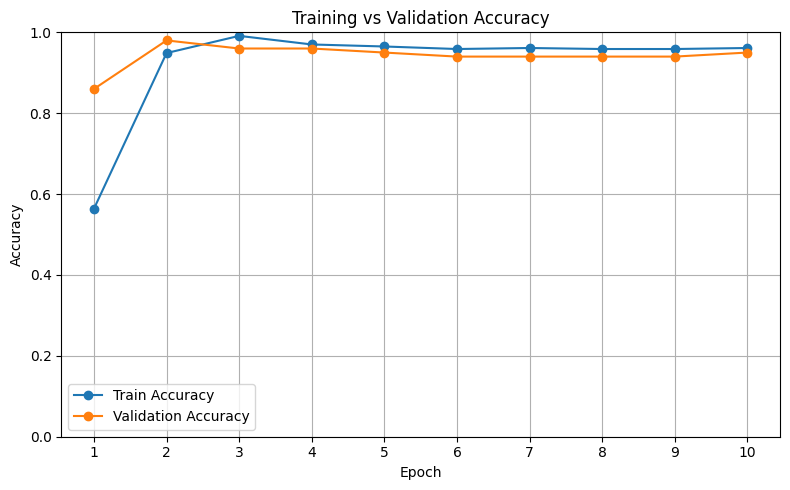

In [22]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy', marker='o')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy', marker='o')
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.xticks(range(1, num_epochs + 1))
plt.ylim(0, 1)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Loss Curve

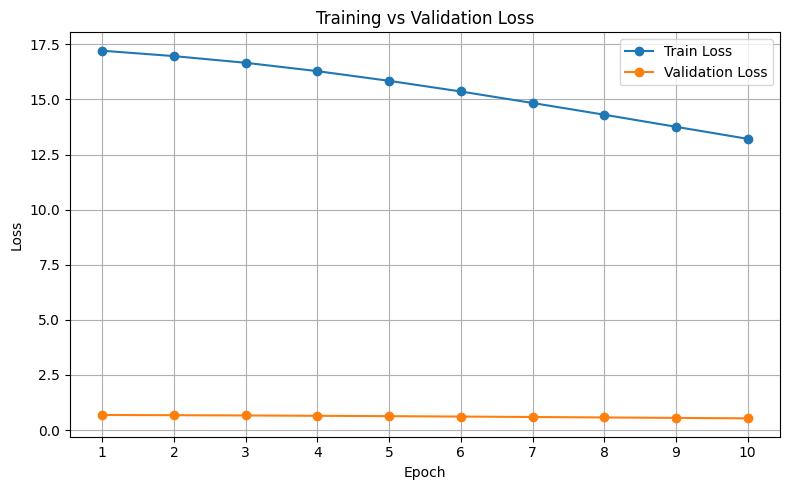

In [23]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', marker='o')
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.xticks(range(1, num_epochs + 1))
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

#Predict on Test Set

In [24]:
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor).squeeze()
    test_preds = (test_outputs >= 0.5).long()

# Confusion Matrix

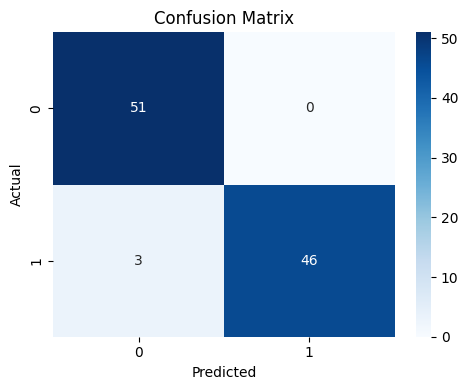

In [25]:
cm = confusion_matrix(y_test_tensor, test_preds)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['0', '1'],
            yticklabels=['0', '1'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# Classification Report

In [26]:
print(classification_report(y_test_tensor, test_preds, digits=4))

              precision    recall  f1-score   support

           0     0.9444    1.0000    0.9714        51
           1     1.0000    0.9388    0.9684        49

    accuracy                         0.9700       100
   macro avg     0.9722    0.9694    0.9699       100
weighted avg     0.9717    0.9700    0.9700       100



# Test Accuracy

In [27]:
test_accuracy = accuracy_score(y_test_tensor, test_preds)
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.9700


## Example

In [28]:
def predict_label(sentences):
    embeddings = embedder.encode(sentences)
    embeddings_tensor = torch.tensor(embeddings, dtype=torch.float32)

    model.eval()
    with torch.no_grad():
        outputs = model(embeddings_tensor).squeeze()
        predicted_labels = (outputs >= 0.5).long().tolist()
    return predicted_labels


# Example
new_sentences = ["The sun is shining brightly.", "The car didn't start this morning"]
predicted_labels = predict_label(new_sentences)
predicted_labels


[1, 0]